[View in Colaboratory](https://colab.research.google.com/github/pamsfwang/perceptual_learning/blob/master/xor_stimuli.ipynb)

In [0]:
import tensorflow as tf
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#Mount Google drive on Colab
#step01
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#step02: code for mounting google drive on Linux
!mkdir -p drive
!google-drive-ocamlfuse drive

#step03: change directory to the google drive folder for the project
os.getcwd()
!ls
os.chdir('./drive/Colab_files')
os.getcwd()
!ls

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
datalab  drive
drive			     notebooks
jfj_stimuli_param.csv	     stimuli_param_uniqueF3.csv
jfj_stimuli_param_test.csv   stimuli_param_uniqueF3_test_new.csv
jfj_stimuli_param_train.csv  stimuli_param_uniqueF3_train_new.csv
models


In [0]:
#specify variables
train_data = 'stimuli_param_uniqueF3_train_new.csv'
test_data = 'stimuli_param_uniqueF3_test_new.csv'

num_features = 3
node_hidden01 = 10
learning_rate = 0.05

In [120]:
#load data
df=pd.read_csv(train_data, sep=',',header=None)
df.shape
nsamples =df.shape[0]
print "number of training samples:",nsamples

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
x_data = temp.values
print "dimension of feature dataset:",x_data.shape
print(x_data[0:5,:])

temp = df.iloc[:,num_features]
y_data = temp.values
print "dimension of category dataset:",y_data.shape
print(y_data[0:5])

number of training samples: 52
dimension of feature dataset: (52, 3)
[[1.  1.  2.2]
 [1.  1.  2.5]
 [1.  2.  5. ]
 [1.  2.  0.3]
 [1.  3.  3.1]]
dimension of category dataset: (52,)
[1 1 1 1 1]


In [121]:
#load test data
df=pd.read_csv(test_data, sep=',',header=None)
df.shape
print "number of test samples:",df.shape[0]

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
test_x_data = temp.values
print "dimension of feature dataset:",test_x_data.shape
print(test_x_data)

temp = df.iloc[:,num_features]
test_y_data = temp.values
print "dimension of category dataset:",test_y_data.shape
print(test_y_data)

number of test samples: 16
dimension of feature dataset: (16, 3)
[[1.  0.  1.2]
 [1.  1.  4.2]
 [2.  0.  5.7]
 [2.  1.  1.8]
 [2.  4.  5.7]
 [3.  0.  2.1]
 [3.  1.  5.3]
 [4.  0.  5.7]
 [1.  4.  4.2]
 [2.  3.  0. ]
 [2.  4.  1.8]
 [3.  3.  4.2]
 [3.  4.  1.6]
 [3.  0.  1.1]
 [4.  3.  6.2]
 [4.  4.  4.2]]
dimension of category dataset: (16,)
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


In [0]:
#You can think of most the tensorflow variables as actually being functions that we will call when we want to get their value. 
input_ph = tf.placeholder(tf.float32, shape=[num_features,1]) #This will be the place the input to the network is inserted
#shape: number of features

target_ph =  tf.placeholder(tf.float32, shape=[1,1]) #This will be the place the target for the network is insertedd
#shape = number of node

W1 = tf.Variable(tf.random_uniform([node_hidden01,num_features],-1,1)) #First layer weights
#first layer: 3 input feautres to 10 nodes in the hidden layer

b1 = tf.Variable(tf.random_uniform([node_hidden01,1],-1,1)) # " " biases
#one node to the 10 nodes in the hidden layer
#[# nodes, # nodes], sampling from a random uniform distribution from -1 to 1 for initial weights

W2 = tf.Variable(tf.random_uniform([1,node_hidden01],-1,1)) #2nd layer
b2 = tf.Variable(tf.random_uniform([1],-1,1))

h1 = tf.nn.tanh(tf.matmul(W1,input_ph)+b1)
#y = tanh(x1w11+x2w21)
#tf.matmul: matrix multiplication

output = tf.nn.tanh(tf.matmul(W2,h1)+b2) #This is the actual construction of the network. When we want to get the output of the network, we will tell tensorflow what to put in the input placeholder, and then we'll run this output function

loss = tf.reduce_sum(tf.square(output - target_ph)) #This is the function we're trying to optimize. The reduce_sum is not really necessary since we only have a single output, just using it to flatten the output.
optimizer = tf.train.AdamOptimizer(learning_rate) #This is a fancy version of momentum based gradient descent optimization.
train = optimizer.minimize(loss) #This will be how we tell the network to train on an example


In [0]:
# Launch the graph -- tell tensorflow to initialize everything.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) #first argument to sess.run is function to run, here we're running the initialize function


In [0]:
def test():
    MSE = 0.0
    for i in xrange(len(test_x_data)):
      MSE += sess.run(loss,feed_dict={input_ph: test_x_data[i].reshape([3,1]),target_ph: test_y_data[i].reshape([1,1])}) #test on a test data point. feed_dict is how you pass things in to the placeholders created above
      MSE /= 4
    return MSE

def accuracy():
    temp =[] 
    for i in xrange(len(test_y_data)):
        temp.append(sess.run(output,feed_dict={input_ph: test_x_data[i].reshape([3,1])}))
    return temp
    
    
def hidden():
    temp = []
    for i in xrange(len(test_y_data)):
        temp.append(sess.run(h1,feed_dict={input_ph: test_x_data[i].reshape([3,1])}))
    return temp

In [125]:
# Fit the function
print "Pre training MSE:", test
ac = []
hid = []
los = []
for step in xrange(1000):
    sess.run(train,feed_dict={input_ph: x_data[step % nsamples].reshape([3,1]),target_ph: y_data[step % nsamples].reshape([1,1])}) 
    #sess.run(train): this will train the model, update the weights
    #Run training on an example
    ac.append(accuracy())
    hid.append(hidden())
    los.append(test())
    if step % 100 == 0:
	print "On step %i, test MSE %f" %(step,test())
 
print "Post training MSE:", test()

print "Final weights:"
print(sess.run(W1),sess.run(b1),sess.run(W2),sess.run(b2))

Pre training MSE: <function test at 0x7f46fcca8500>
On step 0, test MSE 0.262677
On step 100, test MSE 0.132984
On step 200, test MSE 0.333301
On step 300, test MSE 0.333299
On step 400, test MSE 0.333297
On step 500, test MSE 0.333296
On step 600, test MSE 0.333294
On step 700, test MSE 0.333291
On step 800, test MSE 0.333287
On step 900, test MSE 0.333282
Post training MSE: 0.33327574368560653
Final weights:
(array([[-0.7296855 , -0.15510575, -0.89871866],
       [ 0.49007463, -0.24390739,  1.2640802 ],
       [-1.3769643 ,  0.11265108, -1.5781204 ],
       [-0.09519171, -0.23981698, -0.40158165],
       [-0.30631584,  0.5832941 ,  0.6109769 ],
       [-0.35774532, -0.06444861, -0.33934864],
       [-0.5260562 ,  0.65897083,  0.2961003 ],
       [-1.3532478 , -0.21825251, -1.3706481 ],
       [ 1.5223179 ,  1.222654  ,  1.3816328 ],
       [-0.14999314,  1.488334  ,  0.5175745 ]], dtype=float32), array([[-1.5760164 ],
       [ 1.4259529 ],
       [-0.35864538],
       [-0.39881206],


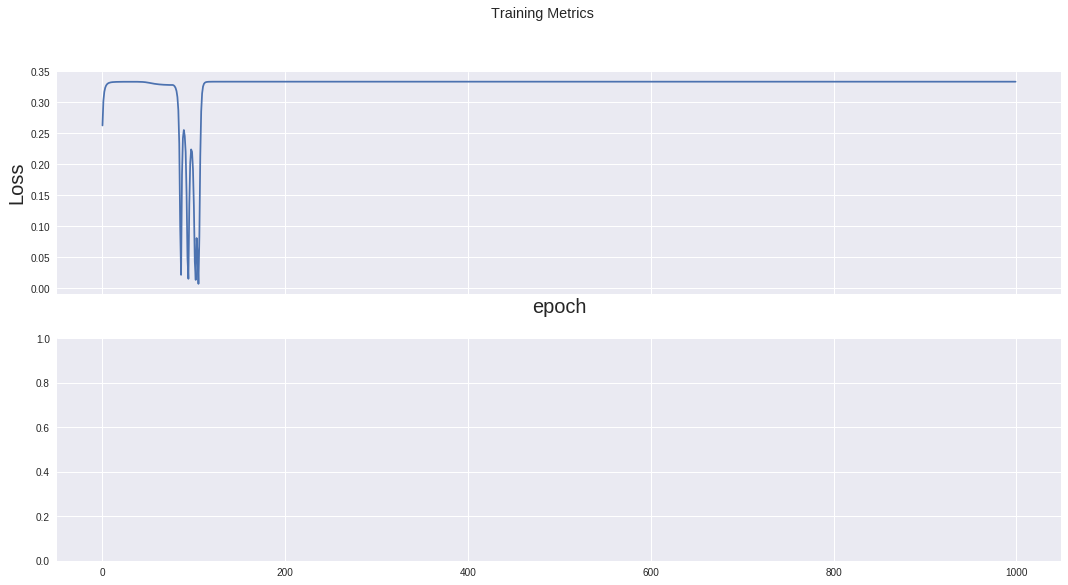

In [130]:
fig, axes = plt.subplots(2, sharex=True, figsize=(18, 9))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=20)
axes[0].set_xlabel("epoch", fontsize = 20)
axes[0].plot(los)

#axes[1].set_ylabel("Accuracy", fontsize=14)
#axes[1].set_xlabel("Epoch", fontsize=14)
#axes[1].plot(ac)

plt.show()

In [111]:
los

[0.06451091810522015,
 0.06809523417872071,
 0.07193364825782111,
 0.07552856143865477,
 0.07888645475080447,
 0.0819697087674506,
 0.08479339879195485,
 0.0873982359094439,
 0.08977011490726199,
 0.0921130979762298]